The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-beta0


# The Transformer Architecture
:label:`sec_transformer`


We have compared CNNs, RNNs, and self-attention in
:numref:`subsec_cnn-rnn-self-attention`.
Notably, self-attention
enjoys both parallel computation and
the shortest maximum path length.
Therefore naturally,
it is appealing to design deep architectures
by using self-attention.
Unlike earlier self-attention models
that still rely on RNNs for input representations :cite:`Cheng.Dong.Lapata.2016,Lin.Feng.Santos.ea.2017,Paulus.Xiong.Socher.2017`,
the Transformer model
is solely based on attention mechanisms
without any convolutional or recurrent layer :cite:`Vaswani.Shazeer.Parmar.ea.2017`.
Though originally proposed
for sequence to sequence learning on text data,
Transformers have been
pervasive in a wide range of
modern deep learning applications,
such as in areas of language, vision, speech, and reinforcement learning.


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from d2l import tensorflow as d2l

## Model

As an instance of the encoder-decoder
architecture,
the overall architecture of
the Transformer
is presented in :numref:`fig_transformer`.
As we can see,
the Transformer is composed of an encoder and a decoder.
Different from
Bahdanau attention
for sequence to sequence learning
in :numref:`fig_s2s_attention_details`,
the input (source) and output (target)
sequence embeddings
are added with positional encoding
before being fed into
the encoder and the decoder
that stack modules based on self-attention.

![The Transformer architecture.](http://d2l.ai/_images/transformer.svg)
:width:`400px`
:label:`fig_transformer`


Now we provide an overview of the
Transformer architecture in :numref:`fig_transformer`.
On a high level,
the Transformer encoder is a stack of multiple identical layers,
where each layer
has two sublayers (either is denoted as $\mathrm{sublayer}$).
The first
is a multi-head self-attention pooling
and the second is a positionwise feed-forward network.
Specifically,
in the encoder self-attention,
queries, keys, and values are all from the
outputs of the previous encoder layer.
Inspired by the ResNet design in :numref:`sec_resnet`,
a residual connection is employed
around both sublayers.
In the Transformer,
for any input $\mathbf{x} \in \mathbb{R}^d$ at any position of the sequence,
we require that $\mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$ so that
the residual connection $\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$ is feasible.
This addition from the residual connection is immediately
followed by layer normalization :cite:`Ba.Kiros.Hinton.2016`.
As a result, the Transformer encoder outputs a $d$-dimensional vector representation
for each position of the input sequence.

The Transformer decoder is also a stack of multiple identical layers
with residual connections and layer normalizations.
Besides the two sublayers described in
the encoder, the decoder inserts
a third sublayer, known as
the encoder-decoder attention,
between these two.
In the encoder-decoder attention,
queries are from the
outputs of the previous decoder layer,
and the keys and values are
from the Transformer encoder outputs.
In the decoder self-attention,
queries, keys, and values are all from the
outputs of the previous decoder layer.
However, each position in the decoder is
allowed to only attend to all positions in the decoder
up to that position.
This *masked* attention
preserves the auto-regressive property,
ensuring that the prediction only depends
on those output tokens that have been generated.


We have already described and implemented
multi-head attention based on scaled dot-products
in :numref:`sec_multihead-attention`
and positional encoding in :numref:`subsec_positional-encoding`.
In the following, we will implement
the rest of the Transformer model.

## [**Positionwise Feed-Forward Networks**]
:label:`subsec_positionwise-ffn`

The positionwise feed-forward network transforms
the representation at all the sequence positions
using the same MLP.
This is why we call it *positionwise*.
In the implementation below,
the input `X` with shape
(batch size, number of time steps or sequence length in tokens,
number of hidden units or feature dimension)
will be transformed by a two-layer MLP into
an output tensor of shape
(batch size, number of time steps, `ffn_num_outputs`).


In [2]:
class PositionWiseFFN(tf.keras.layers.Layer):  #@save
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(ffn_num_hiddens)
        self.relu = tf.keras.layers.ReLU()
        self.dense2 = tf.keras.layers.Dense(ffn_num_outputs)

    def call(self, X):
        return self.dense2(self.relu(self.dense1(X)))

The following example
shows that [**the innermost dimension
of a tensor changes**] to
the number of outputs in
the positionwise feed-forward network.
Since the same MLP transforms
at all the positions,
when the inputs at all these positions are the same,
their outputs are also identical.


In [3]:
ffn = PositionWiseFFN(4, 8)
ffn(tf.ones((2, 3, 4)))[0]

<tf.Tensor: shape=(3, 8), dtype=float32, numpy=
array([[ 0.00115666, -0.00432961,  0.6458616 , -0.35182962,  0.23367424,
        -0.13644473,  0.00161174, -0.01481752],
       [ 0.00115666, -0.00432961,  0.6458616 , -0.35182962,  0.23367424,
        -0.13644473,  0.00161174, -0.01481752],
       [ 0.00115666, -0.00432961,  0.6458616 , -0.35182962,  0.23367424,
        -0.13644473,  0.00161174, -0.01481752]], dtype=float32)>

## Residual Connection and Layer Normalization

Now let's focus on the "add & norm" component in :numref:`fig_transformer`.
As we described at the beginning of this section,
this is a residual connection immediately
followed by layer normalization.
Both are key to effective deep architectures.

In :numref:`sec_batch_norm`,
we explained how batch normalization
recenters and rescales across the examples within
a minibatch.
As discussed in :numref:`subsec_layer-normalization-in-bn`,
layer normalization is the same as batch normalization
except that the former
normalizes across the feature dimension,
thus enjoying benefits of scale independence and batch size independence.
Despite its pervasive applications
in computer vision,
batch normalization
is usually empirically
less effective than layer normalization
in natural language processing
tasks, whose inputs are often
variable-length sequences.

The following code snippet
[**compares the normalization across different dimensions
by layer normalization and batch normalization**].


In [4]:
ln = tf.keras.layers.LayerNormalization()
bn = tf.keras.layers.BatchNormalization()
X = tf.constant([[1, 2], [2, 3]], dtype=tf.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X, training=True))

layer norm: tf.Tensor(
[[-0.998006   0.9980061]
 [-0.9980061  0.998006 ]], shape=(2, 2), dtype=float32) 
batch norm: tf.Tensor(
[[-0.998006   -0.9980061 ]
 [ 0.9980061   0.99800587]], shape=(2, 2), dtype=float32)


Now we can implement the `AddNorm` class
[**using a residual connection followed by layer normalization**].
Dropout is also applied for regularization.


In [5]:
class AddNorm(tf.keras.layers.Layer):  #@save
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.ln = tf.keras.layers.LayerNormalization(norm_shape)

    def call(self, X, Y, **kwargs):
        return self.ln(self.dropout(Y, **kwargs) + X)

The residual connection requires that
the two inputs are of the same shape
so that [**the output tensor also has the same shape after the addition operation**].


In [6]:
# Normalized_shape is: [i for i in range(len(input.shape))][1:]
add_norm = AddNorm([1, 2], 0.5)
shape = (2, 3, 4)
d2l.check_shape(add_norm(tf.ones(shape), tf.ones(shape), training=False),
                shape)

## Encoder
:label:`subsec_transformer-encoder`

With all the essential components to assemble
the Transformer encoder,
let's start by
implementing [**a single layer within the encoder**].
The following `TransformerEncoderBlock` class
contains two sublayers: multi-head self-attention and positionwise feed-forward networks,
where a residual connection followed by layer normalization is employed
around both sublayers.


In [7]:
class TransformerEncoderBlock(tf.keras.layers.Layer):  #@save
    """The Transformer encoder block."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_hiddens, num_heads, dropout, bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def call(self, X, valid_lens, **kwargs):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens, **kwargs),
                          **kwargs)
        return self.addnorm2(Y, self.ffn(Y), **kwargs)

As we can see,
[**any layer in the Transformer encoder
does not change the shape of its input.**]


In [8]:
X = tf.ones((2, 100, 24))
valid_lens = tf.constant([3, 2])
norm_shape = [i for i in range(len(X.shape))][1:]
encoder_blk = TransformerEncoderBlock(24, 24, 24, 24, norm_shape, 48, 8, 0.5)
d2l.check_shape(encoder_blk(X, valid_lens, training=False), X.shape)

In the following [**Transformer encoder**] implementation,
we stack `num_blks` instances of the above `TransformerEncoderBlock` classes.
Since we use the fixed positional encoding
whose values are always between -1 and 1,
we multiply values of the learnable input embeddings
by the square root of the embedding dimension
to rescale before summing up the input embedding and the positional encoding.


In [9]:
class TransformerEncoder(d2l.Encoder):  #@save
    """The Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_hiddens, num_heads,
                 num_blks, dropout, bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = tf.keras.layers.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = [TransformerEncoderBlock(
            key_size, query_size, value_size, num_hiddens, norm_shape,
            ffn_num_hiddens, num_heads, dropout, bias) for _ in range(
            num_blks)]

    def call(self, X, valid_lens, **kwargs):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * tf.math.sqrt(
            tf.cast(self.num_hiddens, dtype=tf.float32)), **kwargs)
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens, **kwargs)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

Below we specify hyperparameters to [**create a two-layer Transformer encoder**].
The shape of the Transformer encoder output
is (batch size, number of time steps, `num_hiddens`).


In [10]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [1, 2], 48, 8, 2, 0.5)
d2l.check_shape(encoder(tf.ones((2, 100)), valid_lens, training=False),
                (2, 100, 24))

## Decoder

As shown in :numref:`fig_transformer`,
[**the Transformer decoder
is composed of multiple identical layers**].
Each layer is implemented in the following
`TransformerDecoderBlock` class,
which contains three sublayers:
decoder self-attention,
encoder-decoder attention,
and positionwise feed-forward networks.
These sublayers employ
a residual connection around them
followed by layer normalization.


As we described earlier in this section,
in the masked multi-head decoder self-attention
(the first sublayer),
queries, keys, and values
all come from the outputs of the previous decoder layer.
When training sequence-to-sequence models,
tokens at all the positions (time steps)
of the output sequence
are known.
However,
during prediction
the output sequence is generated token by token;
thus,
at any decoder time step
only the generated tokens
can be used in the decoder self-attention.
To preserve auto-regression in the decoder,
its masked self-attention
specifies  `dec_valid_lens` so that
any query
only attends to
all positions in the decoder
up to the query position.


In [11]:
class TransformerDecoderBlock(tf.keras.layers.Layer):
    # The i-th block in the Transformer decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def call(self, X, state, **kwargs):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = tf.concat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if kwargs["training"]:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = tf.repeat(
                tf.reshape(tf.range(1, num_steps + 1),
                           shape=(-1, num_steps)), repeats=batch_size, axis=0)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens,
                             **kwargs)
        Y = self.addnorm1(X, X2, **kwargs)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens,
                             **kwargs)
        Z = self.addnorm2(Y, Y2, **kwargs)
        return self.addnorm3(Z, self.ffn(Z), **kwargs), state

To facilitate scaled dot-product operations
in the encoder-decoder attention
and addition operations in the residual connections,
[**the feature dimension (`num_hiddens`) of the decoder is
the same as that of the encoder.**]


In [12]:
decoder_blk = TransformerDecoderBlock(24, 24, 24, 24, [1, 2], 48, 8, 0.5, 0)
X = tf.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
d2l.check_shape(decoder_blk(X, state, training=False)[0], X.shape)

Now we [**construct the entire Transformer decoder**]
composed of `num_blks` instances of `TransformerDecoderBlock`.
In the end,
a fully connected layer computes the prediction
for all the `vocab_size` possible output tokens.
Both of the decoder self-attention weights
and the encoder-decoder attention weights
are stored for later visualization.


In [13]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = tf.keras.layers.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = [TransformerDecoderBlock(
            key_size, query_size, value_size, num_hiddens, norm_shape,
            ffn_num_hiddens, num_heads, dropout, i)
                     for i in range(num_blks)]
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def call(self, X, state, **kwargs):
        X = self.pos_encoding(self.embedding(X) * tf.math.sqrt(
            tf.cast(self.num_hiddens, dtype=tf.float32)), **kwargs)
        # 2 attention layers in decoder
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state, **kwargs)
            # Decoder self-attention weights
            self._attention_weights[0][i] = (
                blk.attention1.attention.attention_weights)
            # Encoder-decoder attention weights
            self._attention_weights[1][i] = (
                blk.attention2.attention.attention_weights)
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## [**Training**]

Let's instantiate an encoder-decoder model
by following the Transformer architecture.
Here we specify that
both the Transformer encoder and the Transformer decoder
have 2 layers using 4-head attention.
Similar to :numref:`sec_seq2seq_training`,
we train the Transformer model
for sequence to sequence learning on the English-French machine translation dataset.


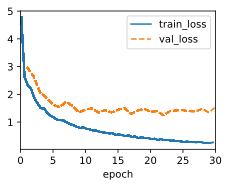

In [14]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
key_size, query_size, value_size = 256, 256, 256
norm_shape = [2]
with d2l.try_gpu():
    encoder = TransformerEncoder(
        len(data.src_vocab), key_size, query_size, value_size, num_hiddens,
        norm_shape, ffn_num_hiddens, num_heads, num_blks, dropout)
    decoder = TransformerDecoder(
        len(data.tgt_vocab), key_size, query_size, value_size, num_hiddens,
        norm_shape, ffn_num_hiddens, num_heads, num_blks, dropout)
    model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                        lr=0.0015)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)

After training,
we use the Transformer model
to [**translate a few English sentences**] into French and compute their BLEU scores.


In [15]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['<unk>', '!'], bleu,0.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '<unk>', '.'], bleu,0.803


Let's [**visualize the Transformer attention weights**] when translating the last English sentence into French.
The shape of the encoder self-attention weights
is (number of encoder layers, number of attention heads, `num_steps` or number of queries, `num_steps` or number of key-value pairs).


In [16]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
enc_attention_weights = tf.concat(model.encoder.attention_weights, 0)
shape = (num_blks, num_heads, -1, data.num_steps)
enc_attention_weights = tf.reshape(enc_attention_weights, shape)
d2l.check_shape(enc_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

In the encoder self-attention,
both queries and keys come from the same input sequence.
Since padding tokens do not carry meaning,
with specified valid length of the input sequence,
no query attends to positions of padding tokens.
In the following,
two layers of multi-head attention weights
are presented row by row.
Each head independently attends
based on a separate representation subspaces of queries, keys, and values.


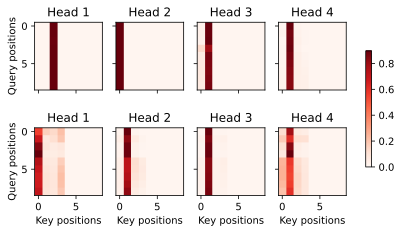

In [17]:
d2l.show_heatmaps(
    enc_attention_weights, xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

[**To visualize both the decoder self-attention weights and the encoder-decoder attention weights,
we need more data manipulations.**]
For example,
we fill the masked attention weights with zero.
Note that
the decoder self-attention weights
and the encoder-decoder attention weights
both have the same queries:
the beginning-of-sequence token followed by
the output tokens and possibly
end-of-sequence tokens.


In [18]:
dec_attention_weights_2d = [head[0] for step in dec_attention_weights
                            for attn in step
                            for blk in attn for head in blk]
dec_attention_weights_filled = tf.convert_to_tensor(
    np.asarray(pd.DataFrame(dec_attention_weights_2d).fillna(
        0.0).values).astype(np.float32))
dec_attention_weights = tf.reshape(dec_attention_weights_filled, shape=(
    -1, 2, num_blks, num_heads, data.num_steps))
dec_self_attention_weights, dec_inter_attention_weights = tf.transpose(
    dec_attention_weights, perm=(1, 2, 3, 0, 4))

In [19]:
d2l.check_shape(dec_self_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))
d2l.check_shape(dec_inter_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

Due to the auto-regressive property of the decoder self-attention,
no query attends to key-value pairs after the query position.


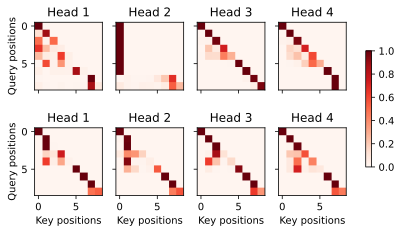

In [20]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

Similar to the case in the encoder self-attention,
via the specified valid length of the input sequence,
[**no query from the output sequence
attends to those padding tokens from the input sequence.**]


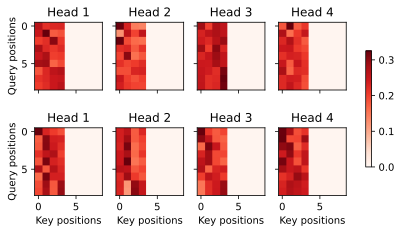

In [21]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

Although the Transformer architecture
was originally proposed for sequence-to-sequence learning,
as we will discover later in the book,
either the Transformer encoder
or the Transformer decoder
is often individually used
for different deep learning tasks.

## Summary

The Transformer is an instance of the encoder-decoder architecture,
though either the encoder or the decoder can be used individually in practice.
In the Transformer architecture, multi-head self-attention is used
for representing the input sequence and the output sequence,
though the decoder has to preserve the auto-regressive property via a masked version.
Both the residual connections and the layer normalization in the Transformer
are important for training a very deep model.
The positionwise feed-forward network in the Transformer model
transforms the representation at all the sequence positions using the same MLP.


## Exercises

1. Train a deeper Transformer in the experiments. How does it affect the training speed and the translation performance?
1. Is it a good idea to replace scaled dot-product attention with additive attention in the Transformer? Why?
1. For language modeling, should we use the Transformer encoder, decoder, or both? How to design this method?
1. What can be challenges to Transformers if input sequences are very long? Why?
1. How to improve computational and memory efficiency of Transformers? Hint: you may refer to the survey paper by :citet:`Tay.Dehghani.Bahri.ea.2020`.


[Discussions](https://discuss.d2l.ai/t/3871)
